In [149]:
import os.path as osp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from datetime import datetime
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

## All users

In [28]:
# Households --> Consumption Data (Power consumed by household)
# Grid --> Grid Data, (Power into, Power from) 
# solar --> Consumption Data (Power Consumed by household appliances, Power consumed immediately from solar panels)
base_solar = osp.join('useful_solar', 'run_household_solar_1')
grid = osp.join(base_solar, 'gridbalance2016.csv')
solar = osp.join(base_solar, 'power2016_solar_module.csv')
household = osp.join(base_solar, 'power2016Household.csv')
griddata = pd.read_csv(grid, index_col=0)
solardata = pd.read_csv(solar)
householddata = pd.read_csv(household)

In [5]:
# Read all folders and load the power consumption of all households into one frame
dfs = []
for p in glob.glob('useful_solar/*'):
    grid_balance = pd.read_csv(osp.join(p, 'gridbalance2016.csv'), usecols=[0, 3], index_col=0)
    solar_module = pd.read_csv(osp.join(p, 'power2016_solar_module.csv'), usecols=[0, 3], index_col=0)
    production = grid_balance['Power into grid'] + solar_module['Solar Power used']
    dfs.append(production.to_frame())

dfs = pd.concat(dfs, axis=1)
dfs.columns = ['production_h' + p.split('_')[-1] for p in glob.glob('useful_solar/*')]

In [6]:
dt = [datetime(2016, 1, 1)]
for _ in range(len(dfs)-1): 
    dt.append(dt[-1] + timedelta(seconds=60))

dfs['Date'] = dt
dfs.set_index('Date', drop=True, inplace=True)
dfs = dfs.resample('H').mean()

In [7]:
overall_production = dfs.sum(axis=1)
overall_production = overall_production.to_frame()
overall_production.columns = ['OverallProd']

## Combined

In [509]:
def rmse(y_true, y_pred): 
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [8]:
weather = pd.read_csv("Weather-AMS/Climate240.csv", skiprows=27)[:8784]
weather.columns = [c.split(' ')[0] for c in weather.columns]
weather.Local = dfs.index
weather.set_index('Local', inplace=True, drop=True)
weather = weather.drop(columns=['ID'])
weather = weather.astype(float)

In [177]:
cols = ['Irradiation', 'Wind', 'Rain', 'Cloud']

In [429]:
# fulldata = weather[cols]
fulldata = weather[cols]
fulldata['OverallProd'] = overall_production['OverallProd']

/home/arthur/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [153]:
# sns.heatmap(weather.corr(), annot=True, cmap='bwr')
# plt.rcParams['figure.figsize'] = [20, 12]

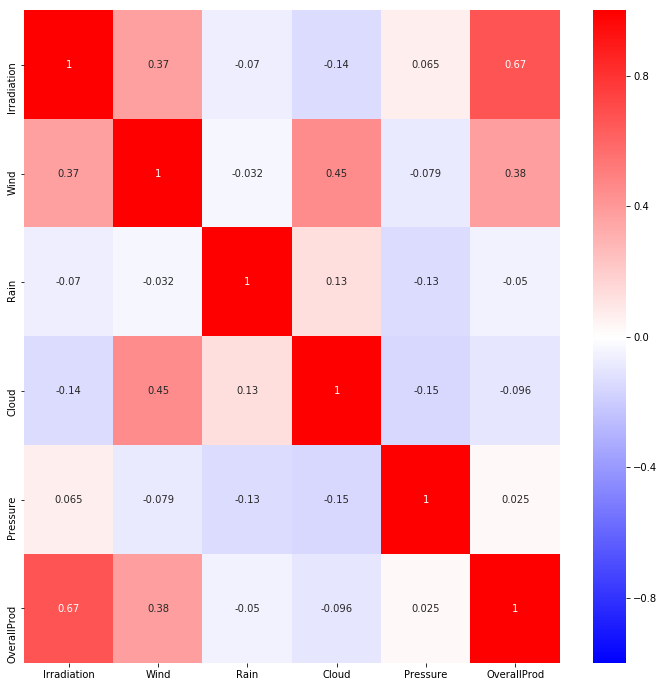

In [154]:
sns.heatmap(fulldata.corr(), annot=True, cmap='bwr', vmin=-1, vmax=1)
plt.rcParams['figure.figsize'] = [12, 12]

In [525]:
lags = 24
# X = fulldata.copy()
# X = fulldata[cols]
X = weather.copy()

for i in range(1, lags+1):
#     X['t-'+str(i)] = fulldata.OverallProd.shift(i)
    X['t-'+str(i)] = fulldata.Irradiation.shift(i)
y = fulldata.OverallProd[lags:]
X = X.drop(columns={'OverallProd'})[lags:]
# X = X[lags:]
# y = fulldata.OverallProd
# y = y.loc[:'2016-06-30']
# X = X.loc[:'2016-06-30']
# X['Hour'] = [i.hour for i in X.index]

In [526]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, shuffle=False)
xgb = XGBRegressor()
xgb.fit(xtrain.values, ytrain);

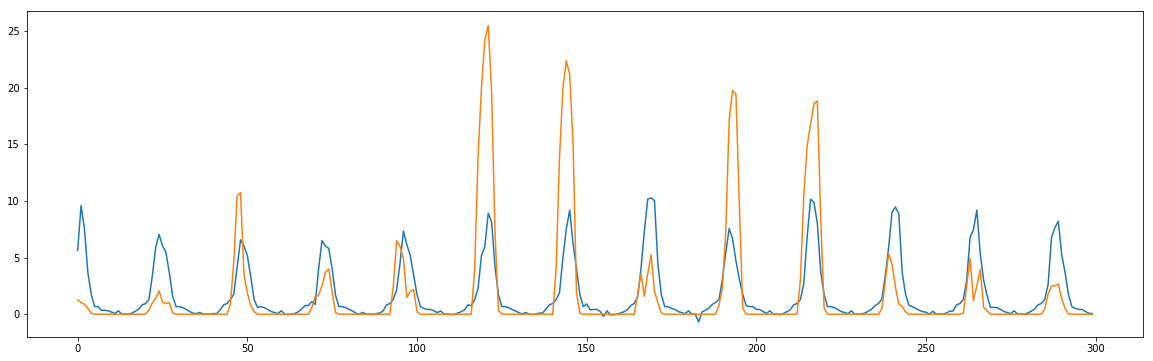

In [536]:
plt.figure(figsize=(20, 6))
pred = xgb.predict(xtest.values)
plt.plot(pred[-300:])
plt.plot(ytest.tolist()[-300:])

In [537]:
rmse(pred, ytest.tolist())/max(ytest)

0.13866968129351295

<BarContainer object of 35 artists>

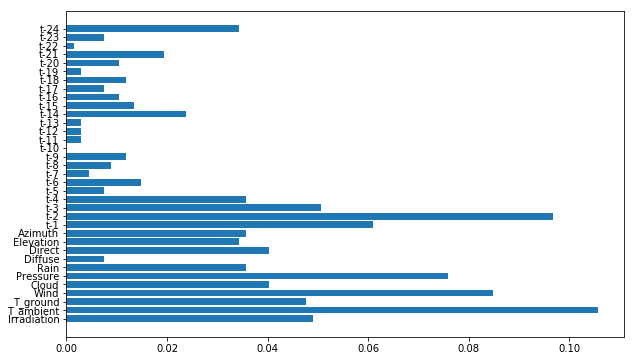

In [538]:
plt.figure(figsize=(10, 6))
plt.barh(X.columns, xgb.feature_importances_)

## Inference

In [179]:
weather[cols].head()

,Irradiation,Wind,Rain,Cloud
Local,,,,
2016-01-01 00:00:00,0.0,5.528,0.065,6.285
2016-01-01 01:00:00,0.0,5.487,0.086,5.931
2016-01-01 02:00:00,0.0,5.659,0.103,5.526
2016-01-01 03:00:00,0.0,5.739,0.065,5.448
2016-01-01 04:00:00,0.0,5.553,0.058,5.832


In [279]:
dfX = X[X.columns[X.columns.str.contains('t-')]].loc[:'2016-07-01']

In [281]:
weather.head(3)

,Irradiation,T_ambient,T_ground,Wind,Cloud,Pressure,Rain,Diffuse,Direct,Elevation,Azimuth,OverallProd
Local,,,,,,,,,,,,
2016-01-01 00:00:00,0.0,3.526,2.251,5.528,6.285,101490.537,0.065,0.0,0.0,-59.404,21.082,0.0
2016-01-01 01:00:00,0.0,3.338,2.169,5.487,5.931,101493.543,0.086,0.0,0.0,-54.394,44.796,0.0
2016-01-01 02:00:00,0.0,3.175,2.093,5.659,5.526,101487.139,0.103,0.0,0.0,-46.972,63.270,0.0


In [282]:
dfX.iloc[-1]

t-1     0.021282
t-2     1.046733
t-3     2.339030
t-4     7.806616
t-5    15.365277
t-6    19.608005
t-7    27.032374
Name: 2016-06-30 23:00:00, dtype: float64

In [283]:
dfX.iloc[-1].values

array([2.12819833e-02, 1.04673250e+00, 2.33903025e+00, 7.80661563e+00,
       1.53652767e+01, 1.96080046e+01, 2.70323740e+01])

In [284]:
weather[cols].head(3)

,Irradiation,Wind,Rain,Cloud
Local,,,,
2016-01-01 00:00:00,0.0,5.528,0.065,6.285
2016-01-01 01:00:00,0.0,5.487,0.086,5.931
2016-01-01 02:00:00,0.0,5.659,0.103,5.526


In [290]:
weather.loc[dt]

Irradiation         0.000
T_ambient          14.921
T_ground           13.025
Wind                3.698
Cloud               4.577
Pressure       101456.020
Rain                0.093
Diffuse             0.000
Direct              0.000
Elevation         -14.492
Azimuth           349.192
OverallProd         0.000
Name: 2016-06-30 23:00:00, dtype: float64

In [293]:
dfX.iloc[-1][:-1]

t-1     0.021282
t-2     1.046733
t-3     2.339030
t-4     7.806616
t-5    15.365277
t-6    19.608005
Name: 2016-06-30 23:00:00, dtype: float64

In [297]:
dfWeather = weather[cols]

In [299]:
list(dfWeather.loc[curtime])

[0.0, 3.698, 0.093, 4.577]

In [306]:
xgb.predict( curx)

array([-0.0874691], dtype=float32)

In [341]:
curx = list(dfWeather.loc[curtime]) + list(dfX.iloc[-1])
preds = []
for i in range(96):
    curtime = dfX.iloc[-1].name + timedelta(hours=i)
    pred = xgb.predict(curx)
    preds.append(pred)
    curx = list(dfWeather.loc[curtime]) + [pred] + list(dfX.iloc[-1][:-1])

In [336]:
fulldata.OverallProd.loc['2016-06-30':'2016-07-03']

Local
2016-06-30 00:00:00     0.000000
2016-06-30 01:00:00     0.000000
2016-06-30 02:00:00     0.000000
2016-06-30 03:00:00     0.000000
2016-06-30 04:00:00     0.000000
2016-06-30 05:00:00     0.125846
2016-06-30 06:00:00     1.013736
2016-06-30 07:00:00     3.293686
2016-06-30 08:00:00     4.956695
2016-06-30 09:00:00     5.151559
2016-06-30 10:00:00     7.943938
2016-06-30 11:00:00     9.500200
2016-06-30 12:00:00    10.038170
2016-06-30 13:00:00    15.691333
2016-06-30 14:00:00    23.177123
2016-06-30 15:00:00    27.707010
2016-06-30 16:00:00    27.032374
2016-06-30 17:00:00    19.608005
2016-06-30 18:00:00    15.365277
2016-06-30 19:00:00     7.806616
2016-06-30 20:00:00     2.339030
2016-06-30 21:00:00     1.046733
2016-06-30 22:00:00     0.021282
2016-06-30 23:00:00     0.000000
2016-07-01 00:00:00     0.000000
2016-07-01 01:00:00     0.000000
2016-07-01 02:00:00     0.000000
2016-07-01 03:00:00     0.000000
2016-07-01 04:00:00     0.000000
2016-07-01 05:00:00     0.068594
    

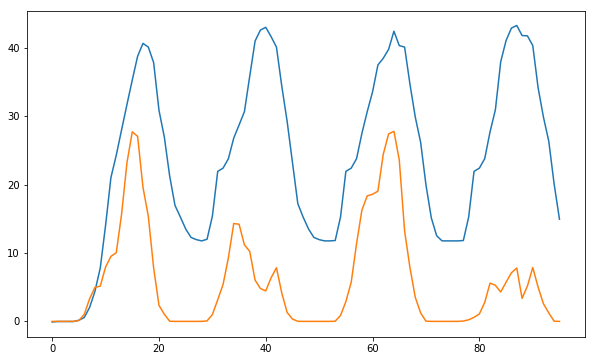

In [343]:
plt.figure(figsize=(10, 6))
plt.plot(preds)
plt.plot(fulldata.OverallProd.loc['2016-06-30':'2016-07-03'].tolist())

In [ ]:
y_hat = xgb.predict(wdf.iloc[-1])

In [542]:
'2016-07-01 00:00:00' + timedelta(hours=24)

TypeError: must be str, not datetime.timedelta

In [543]:
datetime(2016, 7, 1) + timedelta(hours=24)

datetime.datetime(2016, 7, 2, 0, 0)

In [572]:
dfX = X.copy()

In [553]:
curtime = datetime(2016, 7, 1)

In [567]:
import joblib

In [573]:
joblib.dump(xgb, 'inference/xgboost_weather_only.joblib')
dfX.to_pickle('inference/weather_data_shifted.csv')

## INFERENCE

In [574]:
xgb = joblib.load( 'inference/xgboost_weather_only.joblib')
dfX = pd.read_pickle('inference/weather_data_shifted.csv')

In [578]:
preds

array([ 6.23875856e-02,  8.67816806e-03,  8.67816806e-03, -2.08669901e-02,
       -6.41813874e-02,  4.46741283e-02,  1.45303237e+00,  5.11038399e+00,
        8.91939735e+00,  1.49183855e+01,  1.83841877e+01,  2.03157978e+01,
        2.28488922e+01,  2.25096493e+01,  1.88774128e+01,  1.83201923e+01,
        1.95195885e+01,  1.66893196e+01,  1.17347918e+01,  8.84649181e+00,
        3.63238192e+00,  1.38409281e+00,  1.16140485e-01,  6.23875856e-02,
        6.23875856e-02], dtype=float32)

In [581]:
def infer_next(df, regressor, hours=24, curtime=datetime(2016, 7, 1)):
    XX = df.loc[curtime:curtime + timedelta(hours=hours)]
    XX.index
    preds = xgb.predict(XX.values)
    return pd.Series(preds, XX.index)
preds = infer_next(dfX, xgb)

Local
2016-07-01 00:00:00    0.062388
2016-07-01 01:00:00    0.008678
2016-07-01 02:00:00    0.008678
dtype: float32

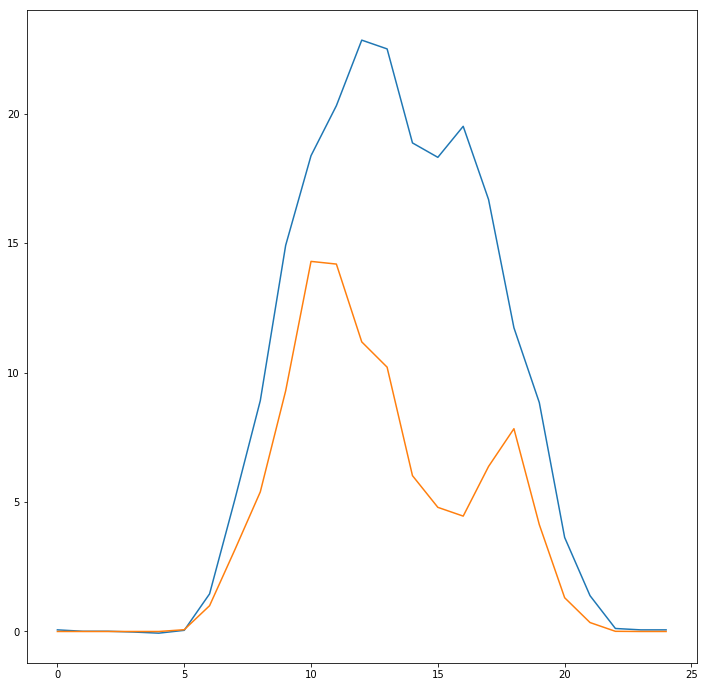

In [577]:
plt.plot(preds)
plt.plot(y.loc[curtime:curtime + timedelta(hours=24)].tolist())